In [381]:
%load_ext autoreload
%autoreload 2
import json
import csv
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


use old data:
    Like reading players in athletic sports. Each person has their own style, first the model has to memorize, later it can be generalized.

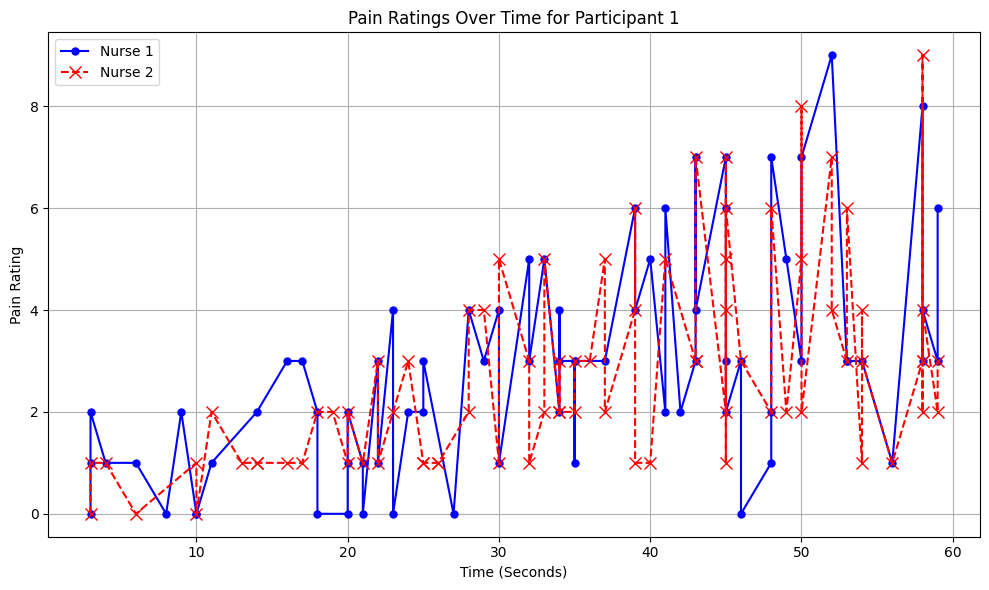

In [2]:
# Load the CSV file, handling duplicate column names and spaces
df = pd.read_csv('Nurses_pain_Scoring.csv', skipinitialspace=True)

# Split data into Nurse 1 and Nurse 2 sections
nurse1_df = df[['Participant', 'Mode', 'Second', 'Pain']].copy()
nurse2_df = df[['Participant.1', 'Mode.1', 'Second.1', 'Pain.1']].copy()

# Rename columns for consistency
nurse1_df.columns = ['Participant', 'Mode', 'Second', 'Pain']
nurse2_df.columns = ['Participant', 'Mode', 'Second', 'Pain']

# Add a column to distinguish nurses
nurse1_df['Nurse'] = 'Nurse 1'
nurse2_df['Nurse'] = 'Nurse 2'

# Combine both datasets
combined = pd.concat([nurse1_df, nurse2_df], ignore_index=True)

# Filter for Participant 1 (convert to string for safety)
#combined['Participant'] = combined['Participant'].astype(str)
participant_1 = combined.copy()#[combined['Participant'].str.strip() == '1']

# Drop rows with missing time or pain data
participant_1 = participant_1.dropna(subset=['Pain'])

nurse1_data = participant_1[participant_1['Nurse'] == 'Nurse 1'].sort_values('Second')
nurse2_data = participant_1[participant_1['Nurse'] == 'Nurse 2'].sort_values('Second')

nurse1 = nurse1_data[nurse1_data['Second']<75]
nurse2 = nurse2_data[nurse2_data['Second']<75]
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(nurse1['Second'], nurse1['Pain'], 'b-o', label='Nurse 1', markersize=5)
plt.plot(nurse2['Second'], nurse2['Pain'], 'r--x', label='Nurse 2', markersize=8)
plt.xlabel('Time (Seconds)')
plt.ylabel('Pain Rating')
plt.title('Pain Ratings Over Time for Participant 1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
participant_to_demonstrate = 6

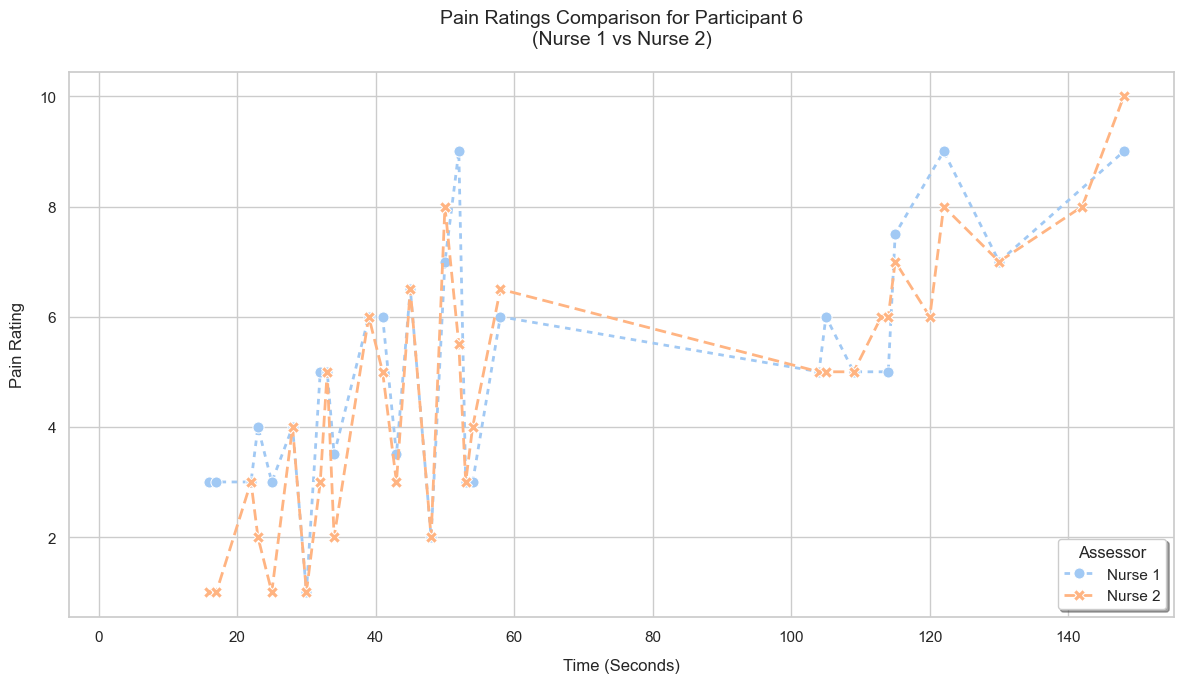

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data and handle headers
df = pd.read_csv('Nurses_pain_Scoring.csv', skipinitialspace=True)

# Split into Nurse 1 and Nurse 2 data
nurse1_df = df[['Participant', 'Mode', 'Second', 'Pain']].copy()
nurse2_df = df[['Participant.1', 'Mode.1', 'Second.1', 'Pain.1']].copy()

# Rename columns for consistency
nurse1_df.columns = ['Participant', 'Mode', 'Second', 'Pain']
nurse2_df.columns = ['Participant', 'Mode', 'Second', 'Pain']

# Forward-fill participant numbers in each dataset
for df_part in [nurse1_df, nurse2_df]:
    df_part['Participant'] = df_part['Participant'].ffill()

# Add nurse identifiers and combine
nurse1_df['Nurse'] = 'Nurse 1'
nurse2_df['Nurse'] = 'Nurse 2'
combined = pd.concat([nurse1_df, nurse2_df], ignore_index=True)

# Clean data
combined = combined.dropna(subset=['Second', 'Pain'])
combined[['Second', 'Pain']] = combined[['Second', 'Pain']].apply(pd.to_numeric, errors='coerce')
combined = combined.dropna(subset=['Second', 'Pain'])

# Filter for Participant
p = participant_to_demonstrate

#participant_1 = combined[combined['Participant'].astype(str).str.strip() == p]
participant_data = combined[combined['Participant'] == p]

# Configure seaborn style
sns.set_theme(style="whitegrid", palette="pastel")
plt.figure(figsize=(12, 7))

# Create line plot with enhanced visibility
sns.lineplot(
    data=participant_data,
    x='Second',
    y='Pain',
    hue='Nurse',
    style='Nurse',
    markers=True,
    dashes=[(2,2), (4,2)],
    markersize=8,
    linewidth=2,
    err_style=None,
)

# Add annotations and styling
plt.title(f'Pain Ratings Comparison for Participant {p}\n(Nurse 1 vs Nurse 2)', pad=20, fontsize=14)
plt.xlabel('Time (Seconds)', labelpad=10)
plt.ylabel('Pain Rating', labelpad=10)
plt.legend(title='Assessor', frameon=True, shadow=True)
plt.tight_layout()

# Add vertical lines for mode changes
for mode_time in participant_1.groupby('Mode')['Second'].min():
    plt.axvline(mode_time, color='gray', linestyle='--', alpha=0.0, lw=1)

plt.show()

In [328]:
# Save each participant's data to separate .csv files
# Load data and handle headers
df = pd.read_csv('Nurses_pain_Scoring.csv', skipinitialspace=True)

# Split into Nurse 1 and Nurse 2 data
nurse1_df = df[['Participant', 'Mode', 'Second', 'Pain', 'Notes']].copy()
nurse2_df = df[['Participant.1', 'Mode.1', 'Second.1', 'Pain.1', 'Notes.1']].copy()
# Rename columns for consistency
nurse1_df.columns = ['Participant', 'Mode', 'Second', 'Pain', 'Notes']
nurse2_df.columns = ['Participant', 'Mode', 'Second', 'Pain', 'Notes']
# Forward-fill participant numbers in each dataset
for df_part in [nurse1_df, nurse2_df]:
    df_part['Participant'] = df_part['Participant'].ffill()
    df_part['Mode'] = df_part['Mode'].ffill()

# Add nurse identifiers and combine
nurse1_df['Nurse'] = 'Nurse 1'
nurse2_df['Nurse'] = 'Nurse 2'
combined = pd.concat([nurse1_df, nurse2_df], ignore_index=True)
# Clean data
combined = combined.dropna(subset=['Second', 'Pain'])
combined[['Second', 'Pain']] = combined[['Second', 'Pain']].apply(pd.to_numeric, errors='coerce')
combined = combined.dropna(subset=['Second', 'Pain'])

#combined.to_csv('forward_filled_nurse_scoring.csv')
#combined[combined['Participant']==5]


In [392]:
p=5

# 2. Ensure correct dtypes
combined['Participant'] = combined['Participant'].astype(int)
combined['Mode'] = combined['Mode'].astype(int)
combined['Second'] = combined['Second'].astype(int)
combined['Pain'] = combined['Pain'].astype(float)
# 'Notes' stays as object (string)

# 3. Compute per-participant, per-mode offsets
offsets = {}
for pid, grp in combined.groupby('Participant'):
    mode_max = grp.groupby('Mode')['Second'].max().sort_index()
    cum = 0
    for mode, max_sec in mode_max.items():
        offsets[(pid, mode)] = cum
        cum += max_sec
        
# 4. Add cumulative seconds
combined['cum_second'] = combined.apply(lambda r: offsets[(r['Participant'], r['Mode'])] + r['Second'], axis=1)
#combined['cum_second'] -= combined.groupby('Participant')['cum_second'].transform('min')

combined[combined['Participant']==p]

,Unnamed: 0,Participant,Mode,Second,Pain,Notes,Nurse,cum_second
72,72,5,1,41,2.0,expressed pain,Nurse 1,41
73,73,5,1,250,3.0,moved hand,Nurse 1,250
74,74,5,1,308,3.0,looks tense,Nurse 1,308
75,75,5,1,327,8.0,asked to stop,Nurse 1,327
76,76,5,2,3,0.0,normal,Nurse 1,330
77,77,5,2,120,7.0,expressed pain and asked to stop,Nurse 1,447
78,78,5,3,20,1.0,verbalization,Nurse 1,472
79,79,5,3,106,4.0,frown,Nurse 1,558
80,80,5,3,122,7.0,expressed pain and asked to stop,Nurse 1,574
81,81,5,4,8,0.0,smiling,Nurse 1,582


In [394]:
# Load and preprocess data
combined = pd.read_csv('nurse_scoring/nurse_evaluation_forward_filled.csv')

# Convert columns to appropriate types
combined['Participant'] = combined['Participant'].astype(int)
combined['Mode'] = combined['Mode'].astype(int)
combined['Second'] = combined['Second'].astype(int)
combined['Pain'] = combined['Pain'].astype(float)

# Step 1: Get max_second for each (Participant, Mode)
max_seconds = (
    combined.groupby(['Participant', 'Mode'])['Second']
    .max()
    .reset_index()
    .rename(columns={'Second': 'max_second'})
)

# Step 2: Generate full grid of all (Participant, Mode, Second) combinations
full_grid_list = []
for idx, row in max_seconds.iterrows():
    participant = row['Participant']
    mode = row['Mode']
    max_sec = row['max_second']
    seconds = np.arange(0, max_sec + 1)
    temp_df = pd.DataFrame({
        'Participant': participant,
        'Mode': mode,
        'Second': seconds
    })
    full_grid_list.append(temp_df)
full_grid = pd.concat(full_grid_list, ignore_index=True)

# Step 3: Pivot original data to wide format (Nurse columns)
wide = combined.pivot_table(
    index=['Participant', 'Mode', 'Second'],
    columns='Nurse',
    values=['Pain', 'Notes'],
    aggfunc='first'
)
wide.columns = [f"{val}_{nurse}" for val, nurse in wide.columns]
wide = wide.reset_index()

# Step 4: Merge full grid with pivoted data
merged = full_grid.merge(
    wide,
    on=['Participant', 'Mode', 'Second'],
    how='left'
)

# Step 5: Forward-fill missing values within each (Participant, Mode) group
merged.sort_values(['Participant', 'Mode', 'Second'], inplace=True)
fill_cols = ['Pain_Nurse 1', 'Pain_Nurse 2',]
merged[fill_cols] = merged.groupby(['Participant', 'Mode'])[fill_cols].ffill()

# Step 6: Fill remaining NaNs (e.g., no prior values to forward-fill)
merged.fillna({
    'Pain_Nurse 1': 0,
    'Pain_Nurse 2': 0,
    'Notes_Nurse 1': '',
    'Notes_Nurse 2': ''
}, inplace=True)

# Ensure integer types
merged[['Participant', 'Mode', 'Second']] = merged[['Participant', 'Mode', 'Second']].astype(int)

# Result
aligned_df = merged
aligned_df['Timestamp']=np.nan
aligned_df.query(f"Participant == {p}").to_csv(f'nurse_scoring/00{p}.csv')

In [395]:
# merge all self-report to one self-report .csv file
# load
p=5
self_df = pd.read_csv(f"self_report/00{p}.csv")
self_df['Participant'] = p
# floor timestamp to the scale of second
self_df['Timestamp'] = pd.to_datetime(self_df['Timestamp'], format="%Y-%m-%d %H:%M:%S.%f")
self_df['Timestamp_sec'] = self_df['Timestamp'].dt.floor('s')
# convert timestamps to relative time w.r.t. start of the session
self_df['cum_second'] = (
    self_df
    .groupby('Participant')['Timestamp_sec']
    .transform(lambda x: (x - x.min()).dt.total_seconds().astype(int))
)
self_df.to_csv(f'self_report/processed/00{p}.csv')
self_df

,Timestamp,PainLevel,Action,Participant,Timestamp_sec,cum_second
0,2025-03-12 12:56:16.613,NaN,Session Started,5,2025-03-12 12:56:16,0
1,2025-03-12 12:58:13.952,1.0,Selected,5,2025-03-12 12:58:13,117
2,2025-03-12 12:58:22.567,2.0,Selected,5,2025-03-12 12:58:22,126
3,2025-03-12 12:58:35.483,3.0,Selected,5,2025-03-12 12:58:35,139
4,2025-03-12 12:58:38.750,4.0,Selected,5,2025-03-12 12:58:38,142
5,2025-03-12 12:58:41.799,5.0,Selected,5,2025-03-12 12:58:41,145
6,2025-03-12 12:58:45.182,6.0,Selected,5,2025-03-12 12:58:45,149
7,2025-03-12 12:58:50.982,7.0,Selected,5,2025-03-12 12:58:50,154
8,2025-03-12 12:58:56.898,8.0,Selected,5,2025-03-12 12:58:56,160
9,2025-03-12 13:00:08.275,8.0,Selected,5,2025-03-12 13:00:08,232


In [ ]:
# concat and align self report to the nurse evaluations
# load
p=7
self_df = pd.read_csv(f"self_report/00{p}.csv")
self_df['Participant'] = p
# floor timestamp to the scale of second
self_df['Timestamp'] = pd.to_datetime(self_df['Timestamp'], format="%Y-%m-%d %H:%M:%S.%f")
self_df['Timestamp_sec'] = self_df['Timestamp'].dt.floor('s')
# convert timestamps to relative time w.r.t. start of the session
self_df['cum_second'] = (
    self_df
    .groupby('Participant')['Timestamp_sec']
    .transform(lambda x: (x - x.min()).dt.total_seconds().astype(int))
)
#self_df['cum_second'] -= 104
# Assume columns: ['Elapsed', 'Pain_self'] or similar; rename Elapsed to cum_second
self_df = self_df.rename(columns={self_df.columns[1]:'Pain_SelfReport'})

self_df
aligned_df_1 = (
    aligned_df
      .query("Participant == 1")            # take only subject 1
      .merge(self_df[["cum_second","Pain_SelfReport"]],
             on="cum_second",
             how="left")
)
# forward fill
aligned_df_1['Pain_SelfReport']= aligned_df_1['Pain_SelfReport'].ffill().fillna(0)
aligned_df_1

In [ ]:
p=5
nurse_df = pd.read_csv(f"nurse_scoring/00{p}.csv") 
nurse_df["Timestamp"] = pd.to_datetime(nurse_df["Timestamp"])

# Extract mode start times and propagate within each mode
nurse_df["mode_start_time"] = nurse_df.groupby("Mode")["Timestamp"].transform("first")

# Calculate absolute timestamp for each evaluation
nurse_df["abs_time"] = nurse_df["mode_start_time"] + \
    pd.to_timedelta(nurse_df["Second"] - nurse_df.groupby("Mode")["Second"].transform('min'), unit="s")
nurse_df["abs_time_sec"] = nurse_df["abs_time"].dt.floor("s")

# Clean unnecessary columns
#nurse_df = nurse_df[["Participant", "Mode", "Second", "Pain_Nurse 1", "Pain_Nurse 2", "abs_time_sec"]]


#nurse_df.to_csv('test.csv')
#nurse_df[nurse_df['Mode']==2]

In [389]:
# Load nurse evaluations data
nurse_df = pd.read_csv(f"nurse_scoring/00{p}.csv")  # 
nurse_df["Timestamp"] = pd.to_datetime(nurse_df["Timestamp"])

# Extract mode start times and propagate within each mode
nurse_df["mode_start_time"] = nurse_df.groupby("Mode")["Timestamp"].transform("first")

# Calculate absolute timestamp for each evaluation
nurse_df["abs_time"] = nurse_df["mode_start_time"] + \
    pd.to_timedelta(nurse_df["Second"] - nurse_df.groupby("Mode")["Second"].transform('min'), unit="s")
nurse_df["abs_time_sec"] = nurse_df["abs_time"].dt.floor("s")

# Clean unnecessary columns
nurse_df = nurse_df[["Participant", "Mode", "Second", "Pain_Nurse 1", "Pain_Nurse 2", "Notes_Nurse 1", "Notes_Nurse 2", "abs_time_sec"]]

# Load self-report data
self_df = pd.read_csv(f"self_report/00{p}.csv")  # 
self_df["Timestamp"] = pd.to_datetime(self_df["Timestamp"])
self_df["Timestamp_sec"] = self_df["Timestamp"].dt.floor("s")

# Clean unnecessary columns
self_df = self_df[["Timestamp_sec", "PainLevel", "Action"]].rename(columns={'PainLevel': 'Pain_SelfReport'})
# Merge dataframes on aligned timestamps
merged_df = pd.merge(
    nurse_df,
    self_df,
    left_on="abs_time_sec",
    right_on="Timestamp_sec",
    how="outer"  # Use "left" or "right" to retain unmatched entries
)

# Sort by time
merged_df = merged_df.sort_values("abs_time_sec")
merged_df['Pain_SelfReport']=merged_df['Pain_SelfReport'].ffill().fillna(0)
# convert to absolute time
merged_df['Second']=(merged_df["abs_time_sec"].astype(int)-merged_df["abs_time_sec"][:1].astype(int).min())/1e9


merged_df.to_csv(f'merged_log/00{p}.csv')

merged_df

,Participant,Mode,Second,Pain_Nurse 1,Pain_Nurse 2,Notes_Nurse 1,Notes_Nurse 2,abs_time_sec,Timestamp_sec,Pain_SelfReport,Action
2,7.0,1.0,0.000000e+00,0.0,0.0,NaN,NaN,2025-03-12 14:22:53,NaT,0.0,NaN
3,7.0,1.0,1.000000e+00,0.0,0.0,NaN,NaN,2025-03-12 14:22:54,NaT,0.0,NaN
4,7.0,1.0,2.000000e+00,0.0,0.0,NaN,NaN,2025-03-12 14:22:55,NaT,0.0,NaN
5,7.0,1.0,3.000000e+00,0.0,0.0,NaN,NaN,2025-03-12 14:22:56,NaT,0.0,NaN
6,7.0,1.0,4.000000e+00,0.0,0.0,NaN,NaN,2025-03-12 14:22:57,NaT,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1491,7.0,5.0,1.600000e+03,6.0,4.0,NaN,NaN,2025-03-12 14:49:33,NaT,10.0,NaN
1492,7.0,5.0,1.601000e+03,6.0,4.0,NaN,NaN,2025-03-12 14:49:34,NaT,10.0,NaN
1493,7.0,5.0,1.602000e+03,9.0,7.0,asked to stop,NaN,2025-03-12 14:49:35,NaT,10.0,NaN
0,NaN,NaN,7.481583e+09,NaN,NaN,NaN,NaN,NaT,2025-03-12 14:20:48,10.0,Session Started


In [378]:
pd.notna(merged_df)

,Participant,Mode,Second,Pain_Nurse 1,Pain_Nurse 2,Notes_Nurse 1,Notes_Nurse 2,abs_time_sec,Timestamp_sec,Pain_SelfReport,Action
1,True,True,True,True,True,False,False,True,False,True,False
2,True,True,True,True,True,False,False,True,False,True,False
3,True,True,True,True,True,False,False,True,False,True,False
4,True,True,True,True,True,False,False,True,False,True,False
5,True,True,True,True,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
334,False,False,True,False,False,False,False,False,True,True,True
335,False,False,True,False,False,False,False,False,True,True,True
506,False,False,True,False,False,False,False,False,True,True,True
507,False,False,True,False,False,False,False,False,True,True,True


In [380]:
merged_df[pd.notna(merged_df['Notes_Nurse 2'])]

,Participant,Mode,Second,Pain_Nurse 1,Pain_Nurse 2,Notes_Nurse 1,Notes_Nurse 2,abs_time_sec,Timestamp_sec,Pain_SelfReport,Action


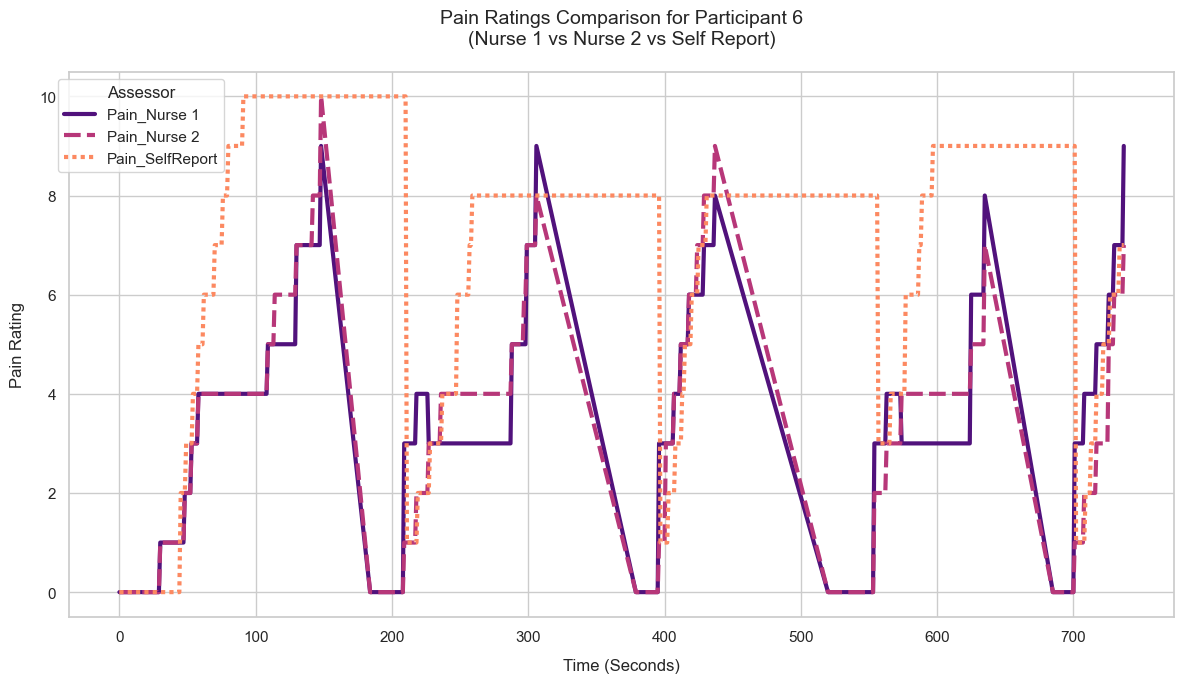

In [363]:
# Configure seaborn style
p=6
merged_df = pd.read_csv(f'merged_log/00{p}.csv',index_col=0)
aligned_df_1 = merged_df
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")
plt.figure(figsize=(12, 7))

# Create line plot with enhanced visibility
ax=sns.lineplot(
    data=aligned_df_1.melt(id_vars=['Participant','Second'],
                        value_vars=['Pain_Nurse 1','Pain_Nurse 2', 'Pain_SelfReport'],
                        var_name='Nurse', value_name='Pain'),
    x='Second',
    y='Pain',
    hue='Nurse',
    style='Nurse',
    #markers=True,
    #dashes=[(2,2), (4,2)],
    markersize=8,
    linewidth=3,
    err_style=None,
    palette='magma'
)

ax.legend(title='Assessor',loc='upper left',bbox_to_anchor=(-0.017, 1))

# Add annotations and styling
plt.title(f'Pain Ratings Comparison for Participant {p}\n(Nurse 1 vs Nurse 2 vs Self Report)', pad=20, fontsize=14)
plt.xlabel('Time (Seconds)', labelpad=10)
plt.ylabel('Pain Rating', labelpad=10)
#plt.legend(title='Assessor', frameon=True, shadow=True)
plt.tight_layout()

plt.show()

In [257]:
# on all ratings
from pingouin import intraclass_corr
from sklearn.metrics import cohen_kappa_score, mean_absolute_error
import krippendorff
#
metrics_by_participant = pd.DataFrame()
#
for p in range(7,8):
    #p=1
    paired = aligned_df_1[aligned_df_1['Participant']==p]
    data = [
        paired['Pain_Nurse 1'].dropna().tolist(), 
        paired['Pain_Nurse 2'].dropna().tolist(),
        paired['Pain_SelfReport'].dropna().tolist(),
    ]
    # melt back to long form if needed
    long = aligned_df_1.melt(id_vars=['Participant','cum_second'],
                        value_vars=['Pain_Nurse 1','Pain_Nurse 2', 'Pain_SelfReport'],
                        var_name='Nurse', value_name='Pain')

    """ icc = intraclass_corr(data=long,
                        targets='Participant',
                        raters='Nurse',
                        ratings='Pain',
                        nan_policy='omit'
                        ) """

    metrics = {
        'Participant': str(p),
        'Cohen’s κ': cohen_kappa_score( paired['Pain_Nurse 2'],paired['Pain_SelfReport']),
        'Weighted κ-1': cohen_kappa_score( paired['Pain_Nurse 2'], paired['Pain_SelfReport'], weights='linear'),
        'Weighted κ-2': cohen_kappa_score( paired['Pain_Nurse 2'], paired['Pain_SelfReport'], weights='quadratic'),
        'MAE': mean_absolute_error( paired['Pain_Nurse 2'], paired['Pain_SelfReport']),
        'Exact Agreement (%)': (paired['Pain_Nurse 2'] == paired['Pain_SelfReport']).mean() * 100,
        'Krippendorff\'s Alpha': krippendorff.alpha(reliability_data=data, level_of_measurement='ordinal'),
        #'CCC': concordance_correlation(paired['Nurse1'], paired['Nurse2']).squeeze(),
    }
    metrics_by_participant = pd.concat([metrics_by_participant, pd.DataFrame(pd.Series(metrics)).transpose()], ignore_index=True)


metrics
#metrics_by_participant['Exact Agreement (%)'] = metrics_by_participant['Exact Agreement (%)']/100
metrics_by_participant

,Participant,Cohen’s κ,Weighted κ-1,Weighted κ-2,MAE,Exact Agreement (%),Krippendorff's Alpha
0,7,0.020533,0.408074,0.624192,2.610022,5.664488,0.566203


In [82]:
from pingouin import intraclass_corr
from sklearn.metrics import cohen_kappa_score, mean_absolute_error
import krippendorff
#
metrics_by_participant = pd.DataFrame()
#
for p in range(1,8):
    #p=1
    paired = aligned_df[aligned_df['Participant']==p]
    data = [
        paired['Pain_Nurse 1'].dropna().tolist(), 
        paired['Pain_Nurse 2'].dropna().tolist()
    ]
    # melt back to long form if needed
    long = aligned_df.melt(id_vars=['Participant','cum_second'],
                        value_vars=['Pain_Nurse 1','Pain_Nurse 2'],
                        var_name='Nurse', value_name='Pain')

    icc = intraclass_corr(data=long,
                        targets='Participant',
                        raters='Nurse',
                        ratings='Pain',
                        )

    metrics = {
        'Participant': str(p),
        'Cohen’s κ': cohen_kappa_score(paired['Pain_Nurse 1'], paired['Pain_Nurse 2']),
        'Weighted κ-1': cohen_kappa_score(paired['Pain_Nurse 1'], paired['Pain_Nurse 2'], weights='linear'),
        'Weighted κ-2': cohen_kappa_score(paired['Pain_Nurse 1'], paired['Pain_Nurse 2'], weights='quadratic'),
        'MAE': mean_absolute_error(paired['Pain_Nurse 1'], paired['Pain_Nurse 2']),
        'Exact Agreement (%)': (paired['Pain_Nurse 1'] == paired['Pain_Nurse 2']).mean() * 100,
        'Krippendorff\'s Alpha': krippendorff.alpha(reliability_data=data, level_of_measurement='ordinal'),
        #'CCC': concordance_correlation(paired['Nurse1'], paired['Nurse2']).squeeze(),
    }
    metrics_by_participant = pd.concat([metrics_by_participant, pd.DataFrame(pd.Series(metrics)).transpose()], ignore_index=True)

icc
metrics
metrics_by_participant['Exact Agreement (%)'] = metrics_by_participant['Exact Agreement (%)']/100
metrics_by_participant

,Participant,Cohen’s κ,Weighted κ-1,Weighted κ-2,MAE,Exact Agreement (%),Krippendorff's Alpha
0,1,0.023484,0.218533,0.317488,1.784219,0.093398,0.289799
1,2,0.18342,0.614177,0.862037,0.679592,0.330612,0.81361
2,3,-0.0198,-0.043989,-0.074065,2.560909,0.067273,-0.143597
3,4,0.278413,0.168814,0.101897,1.034025,0.459751,0.314537
4,5,0.339188,0.36181,0.277937,1.330446,0.438119,0.289518
5,6,0.208728,0.699655,0.910183,0.796137,0.309013,0.843806
6,7,0.021504,0.355567,0.569316,1.790393,0.129549,0.533881


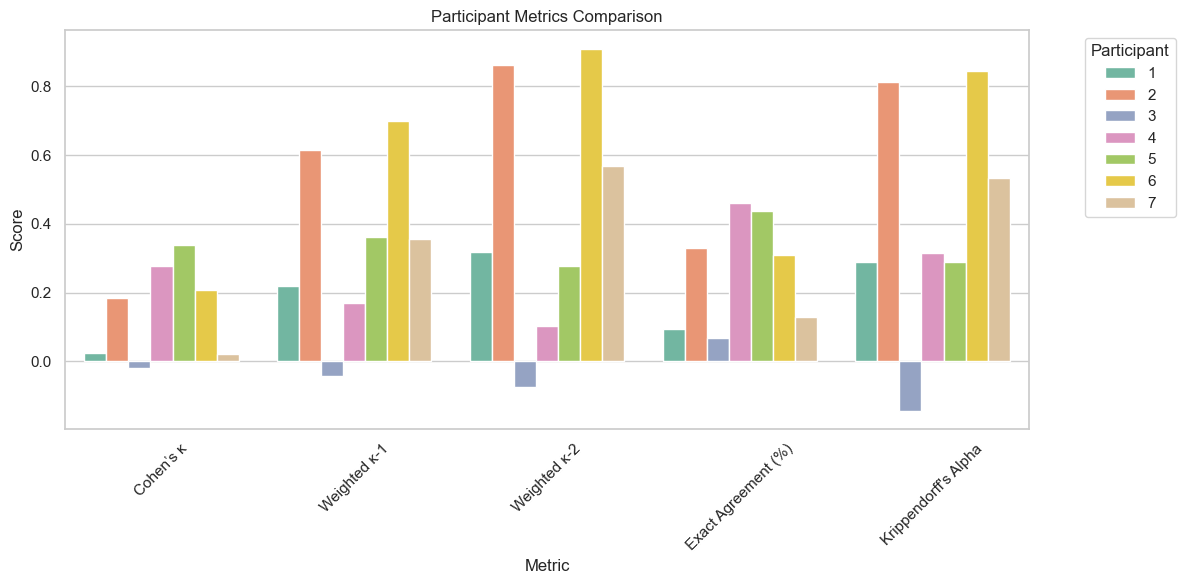

In [84]:
import seaborn as sns

df_long = metrics_by_participant.drop(['MAE'], axis=1).melt(id_vars='Participant', 
                  var_name='Metric', 
                  value_name='Score')

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

sns.barplot(data=df_long, 
            x='Metric', 
            y='Score', 
            hue='Participant', 
            palette='Set2')

plt.title("Participant Metrics Comparison")
plt.xticks(rotation=45)
plt.legend(title='Participant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#sns.barplot(metrics_by_participant, y='Cohen’s κ', x='Participant',)

In [65]:
metrics_by_participant = pd.DataFrame()
#metrics_by_participant = pd.DataFrame(pd.Series(metrics)).transpose()
pd.concat([metrics_by_participant, pd.DataFrame(pd.Series(metrics)).transpose()], ignore_index=True)

,Participant,Cohen’s κ,Weighted κ-1,Weighted κ-2,MAE,Exact Agreement (%),Krippendorff's Alpha
0,1,0.023484,0.218533,0.317488,1.784219,9.339775,0.498014


In [105]:
# Load data and handle headers
df = pd.read_csv('Nurses_pain_Scoring.csv', skipinitialspace=True)

# Split into Nurse 1 and Nurse 2 data
nurse1_df = df[['Participant', 'Mode', 'Second', 'Pain']].copy()
nurse2_df = df[['Participant.1', 'Mode.1', 'Second.1', 'Pain.1']].copy()

# Rename columns for consistency
nurse1_df.columns = ['Participant', 'Mode', 'Second', 'Pain']
nurse2_df.columns = ['Participant', 'Mode', 'Second', 'Pain']

# Forward-fill participant numbers in each dataset
for df_part in [nurse1_df, nurse2_df]:
    df_part['Participant'] = df_part['Participant'].ffill()

# Add nurse identifiers and combine
nurse1_df['Nurse'] = 'Nurse 1'
nurse2_df['Nurse'] = 'Nurse 2'
nurse1_df

,Participant,Mode,Second,Pain,Nurse
0,1.0,1.0,314.0,4.0,Nurse 1
1,1.0,NaN,341.0,4.0,Nurse 1
2,1.0,NaN,405.0,7.0,Nurse 1
3,1.0,2.0,21.0,1.0,Nurse 1
4,1.0,NaN,48.0,7.0,Nurse 1
...,...,...,...,...,...
178,7.0,NaN,NaN,NaN,Nurse 1
179,7.0,NaN,NaN,NaN,Nurse 1
180,7.0,NaN,NaN,NaN,Nurse 1
181,7.0,NaN,NaN,NaN,Nurse 1


In [110]:
import pandas as pd
import numpy as np
from scipy import stats
import pingouin as pg
from tabulate import tabulate

# Load data and clean
df = pd.read_csv('Nurses_pain_Scoring.csv', skipinitialspace=True)

# Extract paired observations (same-row comparisons)
paired = df[['Pain', 'Pain.1']].dropna()
paired.columns = ['Nurse1', 'Nurse2']

In [111]:
#paired=combined
# Calculate metrics
metrics = {
    #'Concordance Correlation (CCC)': pg.concordance_correlation(paired['Nurse1'], paired['Nurse2']).loc['ccc', 'CCC'],
    #'Intra-class Correlation (CCC)': pg.intraclass_corr(paired['Nurse1'], paired['Nurse2'])#.loc['ccc', 'CCC'],
    'Pearson r': stats.pearsonr(paired['Nurse1'], paired['Nurse2'])[0],
    'Spearman rho': stats.spearmanr(paired['Nurse1'], paired['Nurse2'])[0],
    'Mean Absolute Error (MAE)': np.mean(np.abs(paired['Nurse1'] - paired['Nurse2'])),
    'Root Mean Squared Error (RMSE)': np.sqrt(np.mean((paired['Nurse1'] - paired['Nurse2'])**2)),
    'Exact Agreement (%)': np.mean(paired['Nurse1'] == paired['Nurse2']) * 100,
    'Mean Difference (Bland-Altman)': np.mean(paired['Nurse1'] - paired['Nurse2']),
    'Limits of Agreement (±1.96SD)': 1.96*np.std(paired['Nurse1'] - paired['Nurse2'], ddof=1)
}

# Create formatted table
table_data = [[k, f"{v:.3f}" if isinstance(v, float) else f"±{v:.3f}"] 
              for k, v in metrics.items()]

print(tabulate(table_data, headers=['Metric', 'Value'], tablefmt='pretty'))

+--------------------------------+--------+
|             Metric             | Value  |
+--------------------------------+--------+
|           Pearson r            | 0.060  |
|          Spearman rho          | 0.043  |
|   Mean Absolute Error (MAE)    | 2.643  |
| Root Mean Squared Error (RMSE) | 3.189  |
|      Exact Agreement (%)       | 10.714 |
| Mean Difference (Bland-Altman) | 0.179  |
| Limits of Agreement (±1.96SD)  | 6.258  |
+--------------------------------+--------+


In [96]:
pg.intraclass_corr(paired[['Nurse1']], paired[['Nurse2']])

AssertionError: 

In [98]:
paired[['Nurse1']]

,Nurse1
0,4.0
1,4.0
2,7.0
3,1.0
4,7.0
...,...
169,4.0
170,4.0
171,4.0
172,6.0


In [ ]:
# align nurse evaluations
import pandas as pd
import numpy as np

# 2. Ensure correct dtypes
combined['Participant'] = combined['Participant'].astype(int)
combined['Mode'] = combined['Mode'].astype(int)
combined['Second'] = combined['Second'].astype(int)
combined['Pain'] = combined['Pain'].astype(float)
# 'Notes' stays as object (string)

# 3. Compute per-participant, per-mode offsets
offsets = {}
for pid, grp in combined.groupby('Participant'):
    mode_max = grp.groupby('Mode')['Second'].max().sort_index()
    cum = 0
    for mode, max_sec in mode_max.items():
        offsets[(pid, mode)] = cum
        cum += max_sec

# 4. Add cumulative seconds
combined['cum_second'] = combined.apply(lambda r: offsets[(r['Participant'], r['Mode'])] + r['Second'], axis=1)
combined['cum_second'] -= combined.groupby('Participant')['cum_second'].transform('min')

# 5. Pivot to wide, keeping Pain and Notes
wide = combined.pivot_table(
    index=['Participant', 'cum_second', 'Mode'],
    columns='Nurse',
    values=['Pain', 'Notes'],
    aggfunc='first'
)
# Flatten column index
wide.columns = [f"{val}_{nurse}" for val, nurse in wide.columns]
wide = wide.reset_index()

# 6. Build full timeline per participant, merge, then fill forward Mode
aligned_list = []
for pid, grp in wide.groupby('Participant'):
    max_t = grp['cum_second'].max()
    full = pd.DataFrame({
        'Participant': pid,
        'cum_second': np.arange(0, max_t + 1)
    })
    merged = full.merge(grp, on=['Participant', 'cum_second'], how='outer')
    # forward/back-fill Mode for seconds without direct observations
    merged['Mode'] = merged['Mode'].ffill().bfill()
    aligned_list.append(merged)

aligned_df = pd.concat(aligned_list, ignore_index=True)
# forward fill ratings
aligned_df['Pain_Nurse 1'] = pd.DataFrame(aligned_df.groupby(['Participant', 'Mode'])['Pain_Nurse 1'].ffill())
aligned_df['Pain_Nurse 2'] = pd.DataFrame(aligned_df.groupby(['Participant', 'Mode'])['Pain_Nurse 2'].ffill())
#aligned_df['Pain_Nurse 1'] = aligned_df['Pain_Nurse 1'].ffill()
#aligned_df['Pain_Nurse 2'] = aligned_df['Pain_Nurse 2'].ffill()

aligned_df = aligned_df.fillna({'Pain_Nurse 1':0, 'Pain_Nurse 2':0})
#aligned_df.to_csv('nurse_evaluation_aligned_ff.csv')
#aligned_df = aligned_df.iloc[276:]

aligned_df['Timestamp']=np.nan

p=6
aligned_df.query(f"Participant == {p}").to_csv(f'nurse_scoring/00{p}.csv')